[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/3a_transfer_intro.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/notebooks/welcome?src=https://github.com/gibranfp/CurasoAprendizajeProfundo/blob/2023-1/notebooks/3a_transfer_intro.ipynb)
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/3a_transfer_intro.ipynb)

# Clasificando flores usando TL

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).

---

En esta libreta aprenderemos a entrenar clasificadores de imagenes usando [PyTorch](https://pytorch.org/docs/stable/index.html) para el conjunto de flores [Flowers102](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). Usaremos modelos preentrenados en [ImageNet](https://www.image-net.org/) para observar el efecto de la transferencia de conocimiento.

## 0. Preparación

Primero instalemos algunos paquetes e importemos las bibliotecas necesarias.

In [1]:
# install extra libraries
%pip install -q pytorch-lightning timm torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
from os.path import join
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import pytorch_lightning as pl
from IPython.display import display, HTML
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.datasets import Flowers102
from packaging import version

Definamos ahora una función para graficar comportamiento de los modelos durante entrenamiento. 

In [3]:
# auxiliaries

DATA_DIR = '../data'
LABELS_URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/data/flowers-102/labels.csv'
# for Kaggle, fix Flowers102 labels for torchvision < 0.13.0
FIX_LABELS = version.parse(torchvision.__version__) < version.parse('0.13.0')
target_transform = T.Lambda(lambda y: y - 1) if FIX_LABELS else nn.Identity()


def plot_training(models):
    """"Plots loss and accuracy in the `lms` list."""
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
    handles0, handles1 = [], []
    for model in models:
        arch = model.net.arch
        pretraining = model.net.pretraining
        val_loss, val_acc = np.array(model.val_hist).T
        trn_loss, trn_acc = np.array(model.trn_hist).T
        trn_line, = axs[0].plot(trn_loss, label=f'{arch}-{pretraining} Trn')
        val_line, = axs[0].plot(val_loss, label=f'{arch}-{pretraining} Val')
        handles0.extend([trn_line, val_line])
        axs[0].set_title('Loss ↓')
        trn_line, = axs[1].plot(trn_acc, label=f'{arch}-{pretraining} Trn')
        val_line, = axs[1].plot(val_acc, label=f'{arch}-{pretraining} Val')
        handles1.extend([trn_line, val_line])
        axs[1].set_title('Accuracy ↑')
    
    for ax, y_label, handles in [[axs[0], 'loss', handles0],
                                 [axs[1], 'accuracy', handles1]]:
        ax.legend(handles=handles, prop={'size': 9})
        ax.set_xlabel('epoch', fontsize=9)
        ax.set_ylabel(y_label, fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.show()

    
plt.style.use("seaborn")

## 1. Conjunto Flowers102

[Flowers102](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) tiene 102 classes teninendo entre 40 y 258 ejemplos por clase. La clasificación de flores es una tarea de grano fino difícil por las siguientes características.

* Baja variabilidad inter-clase: las diferencias entre las clases pueden ser sutiles.
* Baja variabilidad intra-clase: las diferencias entre los ejemplos de una misma clase pueden ser sutiles.

![Flowers102](https://www.researchgate.net/publication/345039740/figure/fig2/AS:1083904253534265@1635434320486/Oxford-102-Flower-dataset-which-contains-102-categories-of-flowers-can-be-used-for.jpg)

Ejemplos de Flowers102.

### 1.1 Explorando el conjunto

Recordemos que los conjuntos de datos se dividen en:

* el **subconjunto de entrenamiento** para entrenar el modelo y
* el **subconjunto de validación o prueba** que se usa para evaluar el desempeño del modelo.

Buscamos siempre modelos que tengan un buen desempeño en ambos conjuntos ya que esto mejora su capacidad de generalización en datos no vistos.

![Data Partition](https://raw.githubusercontent.com/bereml/riiaa-22-tl/master/figs/dataset_partition.svg)

Ahora descargamos los datos y creamos conjuntos de entrenamiento y validación:

In [4]:
trn_ds = Flowers102(DATA_DIR, 'train', target_transform=target_transform, download=True)
val_ds = Flowers102(DATA_DIR, 'val', target_transform=target_transform)

f'There are {len(trn_ds)} training and {len(val_ds)} validation examples'

'There are 1020 training and 1020 validation examples'

Despleguemos un ejemplo:

![Image Representation](https://raw.githubusercontent.com/bereml/riiaa-22-tl/master/figs/image_representation.svg)

Image PIL: <PIL.Image.Image image mode=RGB size=754x500 at 0x7FA801204550>
Mean of pixel values: 119.60582935455349
Label numeric: 0, string: pink primrose


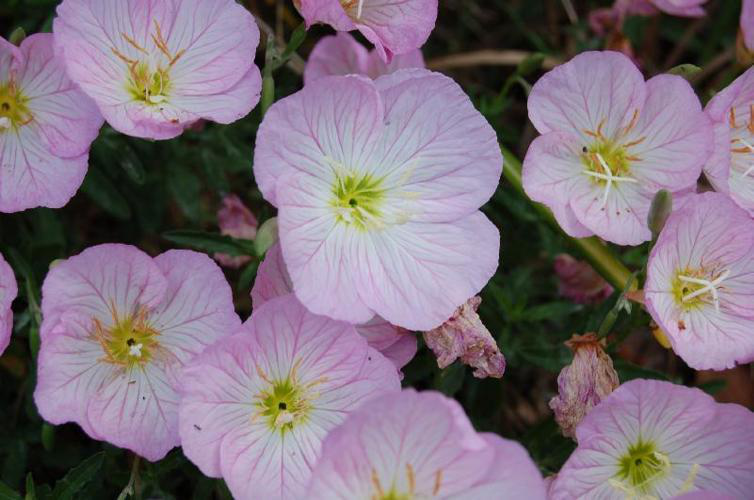

In [5]:
LABELS = pd.read_csv(LABELS_URL).labels

x, y = trn_ds[0]
print(f'Image PIL: {x}')
print(f'Mean of pixel values: {np.array(x).mean()}')
print(f'Label numeric: {y}, string: {LABELS[y]}')
x

### 1.2 Construyendo una tuberia de datos

Un [tuberia de datos](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) es la serie de pasos para leer y preprocesar los datos dejandolos listo para ser ingresar al modelo. Una tuberia tiene dos clases principales:

* [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset): carga un ejemplo y aplica una transformación.
* [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): agrupa los ejemplos y los barajea si es necesario (entrenamiento).

![Data Pipeline](https://raw.githubusercontent.com/bereml/riiaa-22-tl/master/figs/data_pipeline.svg)

Implementemos y probemos la tuberia de datos para nuestros modelos.

In [6]:
PRETRAIN_NORM = {
   'None': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
   'ImageNet1k': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
   'ImageNet21k': ((0., 0., 0.), (1., 1., 1.))
}


def build_dl(subset, pretraining):
    """Builds a dataloader for the `subset` with the correct stats."""
    # get mean and standard deviation
    mean, std = PRETRAIN_NORM.get(pretraining, 'None')

    # assamble preprossing pipeline
    transform = T.Compose([
        # resize to small image
        T.Resize(256),
        # crop to te Center
        T.CenterCrop(224),
        # PIL to Tensor and [0-255] to [0, 1]
        T.ToTensor(),
        # normalize with stats
        T.Normalize(mean, std),
    ])

    # create the dataset
    dataset = Flowers102(DATA_DIR, subset, transform, target_transform)

    # create the dataloader to pack batches
    dataloader = DataLoader(
        dataset, 
        batch_size=32, 
        num_workers=4, 
        shuffle=subset=='train'
    )

    return dataloader

# creates a dataloader
val_dl = build_dl('val', 'None')

# loads the first batch
batch = next(iter(val_dl))
x, y = batch

# inspects batch
print(f'x.shape: {x.shape} x.mean: {x.mean()}')
print(f'y.shape: {y.shape} y[0]: {y[0]}')

x.shape: torch.Size([32, 3, 224, 224]) x.mean: 0.07305947691202164
y.shape: torch.Size([32]) y[0]: 0


## 2. Intento A: entrenando solo con flores

### 2.1 Definiendo una arquitectura sencilla

La primera arquitectura que usaremos será una red convolucional muy sencilla conformada por tres bloques en la columna y una capa completamente conectada como cabeza de clasificación.

In [7]:
def build_conv_block(in_channels, out_channels, num_groups):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 
                  kernel_size=3, stride=1, padding=1),
        nn.GroupNorm(num_groups, out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


class SimpleNet(nn.Module):
    
    def __init__(self, pretraining='None', num_classes=102):
        """Simple ConvNet."""
        super().__init__()
        self.arch = 'SimpleNet'
        self.pretraining = pretraining
        self.backbone = nn.Sequential(
            build_conv_block(3, 8, 2),
            build_conv_block(8, 16, 4),
            build_conv_block(16, 32, 8),
            nn.AdaptiveMaxPool2d((2,2)),
            nn.Flatten()
        )
        self.head = nn.Linear(128, num_classes)

    def forward(self, x):
        # compute features
        x = self.backbone(x)
        # compute logits
        x = self.head(x)
        return x


summary(SimpleNet(), (1, 3, 224, 224), depth=2)

/home/richardt/.miniconda3/envs/riiaa-22/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type:depth-idx)                   Output Shape              Param #
SimpleNet                                [1, 102]                  --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Sequential: 2-1                   [1, 8, 112, 112]          240
│    └─Sequential: 2-2                   [1, 16, 56, 56]           1,200
│    └─Sequential: 2-3                   [1, 32, 28, 28]           4,704
│    └─AdaptiveMaxPool2d: 2-4            [1, 32, 2, 2]             --
│    └─Flatten: 2-5                      [1, 128]                  --
├─Linear: 1-2                            [1, 102]                  13,158
Total params: 19,302
Trainable params: 19,302
Non-trainable params: 0
Total mult-adds (M): 40.46
Input size (MB): 0.60
Forward/backward pass size (MB): 11.24
Params size (MB): 0.08
Estimated Total Size (MB): 11.92

### 2.2 Ciclo de entrenamiento

Para el ciclo de entrenamiento usaremos [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/), una biblioteca que implementa muchos elementos del ciclo para agilizar la experimentación.

![Training Loop](https://raw.githubusercontent.com/bereml/riiaa-22-tl/master/figs/training_loop.svg)

In [8]:
class TrainLM(pl.LightningModule):

    def __init__(self, net):
        super().__init__()
        self.net = net
        self.freeze_backbone = net.pretraining != 'None'
        # historics
        self.trn_batch_hist = []
        self.trn_hist = []
        self.val_batch_hist = []
        self.val_hist = []

    def configure_optimizers(self):
        # creates the optimizer with the net parameters
        return torch.optim.AdamW(self.net.parameters(), lr=1e-3)

    def forward_with_loss(self, batch):
        """Performs infererence and returns loss."""
        # splits batch
        x, y_true = batch
        # computes logit predictions
        y_lgts = self.net(x)
        # computes loss
        loss = F.cross_entropy(y_lgts, y_true)
        # compute probabilities
        with torch.no_grad():
            y_prob = F.softmax(y_lgts, dim=1)
        return y_true, y_prob, loss  
    
    def training_step(self, batch, batch_idx):
        """Training step on a batch."""
        # if net is pretrained, freeze backbone params & stats
        if self.freeze_backbone:
            self.net.freeze_backbone()
        # forward
        y_true, y_prob, loss = self.forward_with_loss(batch)
        # add to epoch history
        self.add_to_history(self.trn_batch_hist, y_true, y_prob, loss)
        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step on a batch."""
        # forward
        y_true, y_prob, loss = self.forward_with_loss(batch)
        # add to epoch history
        self.add_to_history(self.val_batch_hist, y_true, y_prob, loss)
    
    def training_epoch_end(self, outs):
        loss, acc = np.mean(self.trn_batch_hist, 0)
        self.trn_hist.append([loss, acc])
        self.trn_batch_hist = []
    
    def validation_epoch_end(self, outs):
        loss, acc = np.mean(self.val_batch_hist, 0)
        self.val_hist.append([loss, acc])
        self.val_batch_hist = []

    def add_to_history(self, hist, y_true, y_prob, loss):
        acc = sum(y_true == y_prob.argmax(1)) / y_true.shape[0]
        loss = round(loss.item() * 100, 2)
        acc = round(acc.item() * 100, 2)
        hist.append([loss, acc])


def train(Net, pretraining, max_epochs):
    """Trains a model."""
    # reproducibility
    pl.seed_everything(0)

    # create datasets
    trn_dl = build_dl('train', pretraining)
    val_dl = build_dl('val', pretraining)

    # create network
    net = Net(pretraining)
    # create train 
    lm = TrainLM(net)

    # training loop manager
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='auto',
        log_every_n_steps=10,
    )
    # train!
    trainer.fit(lm, trn_dl, val_dl)

    return lm

### 2.3 Entrenamiento

Entrenemos `SimpleNet` con inicialización aleatoria.

In [9]:
simple_none = train(SimpleNet, 'None', 50)

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type      | Params
-----------------------------------
0 | net  | SimpleNet | 19.3 K
-----------------------------------
19.3 K    Trainable params
0         Non-trainable params
19.3 K    Total params
0.077     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


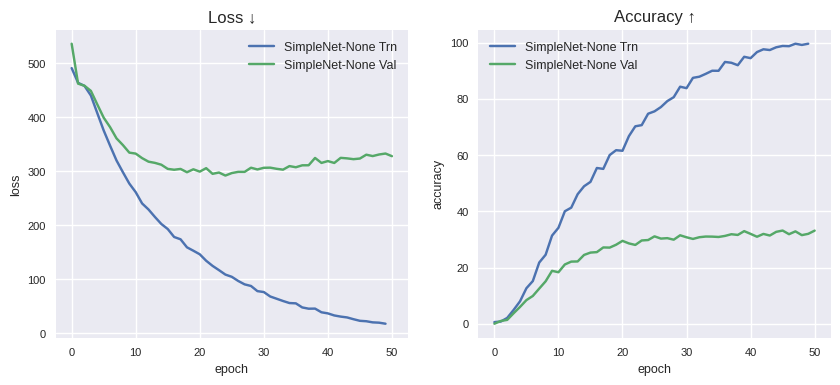

In [10]:
plot_training([simple_none])

Podemos ver que el modelo aparentemente aprende bien en el conjunto de entrenamiento, en la últimas épocas alcanza cerca del 100% de exactitud y un valor de 0 en pérdida. Sin embargo, el desempeño en validación es muy distinto, la exactitud parece estancarse aproximadamente en 30 puntos, mientras que la pérdida alcanza su mínimo en alrededor de la época 23 y comienza a subir. Esto se conoce como el [problema del sobreajuste](https://en.wikipedia.org/wiki/Overfitting): el modelo memoriza los datos entrenamiento pero no puede generalizar ejemplos fuera del conjunto de aprendizaje.

## 3. Intento B: usando TL

Intentemos usar tranferencia de conocimiento para solucionar el sobre ajuste. Vamos a usar la arquitectura ligera [MobileNetV3](https://arxiv.org/pdf/1905.02244.pdf) diseñada para entornos de bajos recursos (sistemas embebidos). La biblioteca [`timm`](https://rwightman.github.io/pytorch-image-models/) implementada esta arquitectura , además provee pesos preentreandos en diferentes versiones de ImageNet.

### 3.1 Inspeccionando MobileNetV3

Primero inspeccionemos estructura de la [implementación](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/mobilenetv3.py) de MobileNetV3 en `timm`.

In [11]:
summary(timm.create_model('mobilenetv3_large_100'), (1, 3, 224, 224), depth=2)

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [1, 1000]                 --
├─Conv2d: 1-1                                 [1, 16, 112, 112]         432
├─BatchNormAct2d: 1-2                         [1, 16, 112, 112]         32
│    └─Identity: 2-1                          [1, 16, 112, 112]         --
│    └─Hardswish: 2-2                         [1, 16, 112, 112]         --
├─Sequential: 1-3                             [1, 960, 7, 7]            --
│    └─Sequential: 2-3                        [1, 16, 112, 112]         464
│    └─Sequential: 2-4                        [1, 24, 56, 56]           7,880
│    └─Sequential: 2-5                        [1, 40, 28, 28]           52,312
│    └─Sequential: 2-6                        [1, 80, 14, 14]           130,824
│    └─Sequential: 2-7                        [1, 112, 14, 14]          600,544
│    └─Sequential: 2-8                        [1, 160, 7, 7]            2,02

### 3.2 Adaptando MobileNetV3

![Flowers102](https://raw.githubusercontent.com/bereml/riiaa-22-tl/master/figs/transfer.svg)

In [12]:
class MobileNetV3(nn.Module):
    """ MobileNetV3 classifier."""

    def __init__(self, pretraining, num_classes=102):
        # call father init
        super().__init__()
        self.arch = 'MobileNetV3'
        self.pretraining = pretraining
        # pretrained config for timm
        model_name, pretrained  = {
            'None': ('mobilenetv3_large_100', False), 
            'ImageNet1k': ('mobilenetv3_large_100', True), 
            'ImageNet21k': ('mobilenetv3_large_100_miil_in21k', True)
        }.get(pretraining, 'ImageNet1k')
        # create the backbone and load weights
        self.backbone = timm.create_model(model_name, pretrained)
        # get last feature vector size
        in_features = self.backbone.classifier.in_features
        # bypass classification block
        self.backbone.classifier = nn.Identity()
        # create classification head
        self.head = nn.Linear(in_features, num_classes)
    
    def freeze_backbone(self):
        """Disables updates on the backbone params & stats."""
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.eval()

    def forward(self, x):
        """Forward pass."""
        # compute features
        x = self.backbone(x)
        # compute logits
        x = self.head(x)
        return x
    
    def predict(self, x):
        """Applies softmax over the forward output."""
        # logits to probabilities
        y_lgts = self.forward(x)
        y_prob = F.softmax(y_lgts, dim=1)
        return y_prob


summary(MobileNetV3('None'), (1, 3, 224, 224), depth=2)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 102]                  --
├─MobileNetV3: 1-1                                 [1, 1280]                 --
│    └─Conv2d: 2-1                                 [1, 16, 112, 112]         432
│    └─BatchNormAct2d: 2-2                         [1, 16, 112, 112]         32
│    └─Sequential: 2-3                             [1, 960, 7, 7]            2,971,488
│    └─SelectAdaptivePool2d: 2-4                   [1, 960, 1, 1]            --
│    └─Conv2d: 2-5                                 [1, 1280, 1, 1]           1,230,080
│    └─Hardswish: 2-6                              [1, 1280, 1, 1]           --
│    └─Flatten: 2-7                                [1, 1280]                 --
│    └─Identity: 2-8                               [1, 1280]                 --
├─Linear: 1-2                                      [1, 102]                  130,662
Total params: 4

### 3.3 Entrenando Modelos

#### Inializacion aletoria

Entrenemos una instancia de `MobileNetV3` inicializada aleatoreamente para comparar su aprendizaje con `SimpleNet`.

In [13]:
mobile_none = train(MobileNetV3, 'None', 25)

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type        | Params
-------------------------------------
0 | net  | MobileNetV3 | 4.3 M 
-------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.331    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


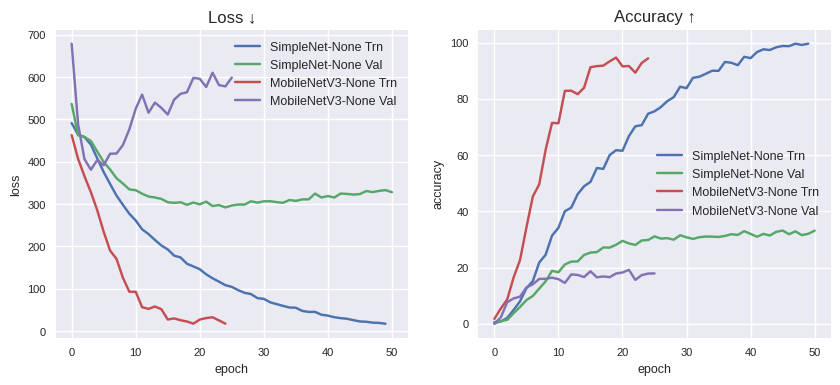

In [14]:
plot_training([simple_none, mobile_none])

Aunque `MobileNetV3` llega máximo de exactitud en menor tiempo, el sobreajuste es peor.

#### Transfiriendo ImageNet1k

Probemos ahora realizando transferencia desde ImageNet1k.

In [15]:
mobile_imagenet1k = train(MobileNetV3, 'ImageNet1k', 10)

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type        | Params
-------------------------------------
0 | net  | MobileNetV3 | 4.3 M 
-------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.331    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


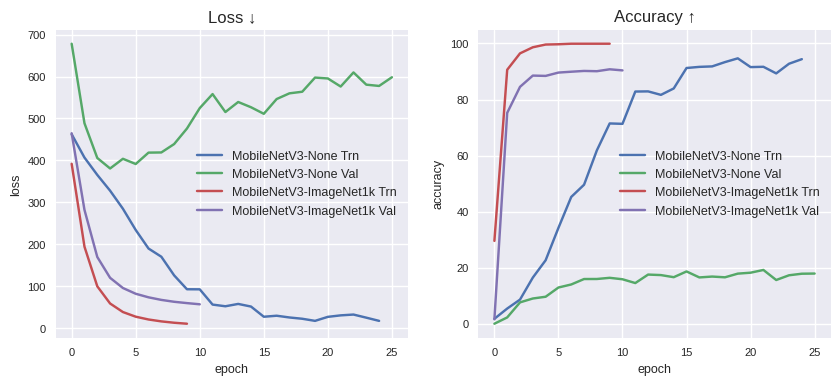

In [16]:
plot_training([mobile_none, mobile_imagenet1k])

Podemos ver que el aprendizaje del modelo preentrenado en ImageNet1k tiene un comportameniento distinto al de los anteriores. La curvas de exactitud de entrenamiento y prueba crecen de forma simultanea, mientras que las pérdidas decrecen de forma conjunta. Podemos decir que este modelo tiene un sobre ajuste bajo, ya que la diferencia entre exactitudes es aceptable.

#### Transfiriendo ImageNet21k

¿Qué tanta diferencia pueden hacer más datos durante el preentrenamiento? Mientras que ImageNet1k cuenta con 1000 clases y al menos 100 ejemplos por clase, ImageNet21k tiene 21000 clases y un número proporcional de ejemplos por clase. Tratemos de responder a esta pregunta entrenando un preentrando en ImageNet21k.

In [17]:
mobile_imagenet21k = train(MobileNetV3, 'ImageNet21k', 5)

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type        | Params
-------------------------------------
0 | net  | MobileNetV3 | 4.3 M 
-------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.331    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


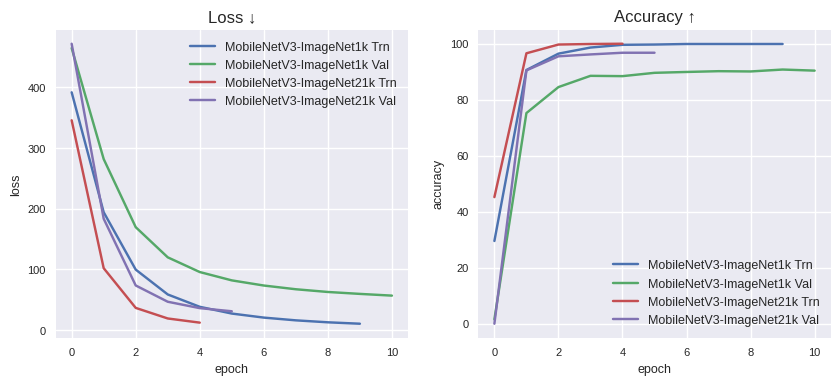

In [18]:
plot_training([mobile_imagenet1k, mobile_imagenet21k])

No solo mejoramos el desempeño en validación y con esto la generalización, si no también requerimos menos entrenamiento que cualquier otro modelo.

## 4. Probando fuera del conjunto

Envolvamos nuestro modelo en una función para predecir a partir de una URL.

In [19]:
def predict(net, image, topk):
    # preprocess
    mean, std = PRETRAIN_NORM[net.pretraining]
    image = TF.resize(image, 256)
    image = TF.center_crop(image, 224)
    batch = TF.to_tensor(image).unsqueeze(0)
    batch = TF.normalize(batch, mean, std)
    # freeze model stats
    net.eval()
    # predict
    with torch.no_grad():
        y_prob = net.predict(batch)
        y_prob = y_prob.squeeze(0) * 100
        probs, classes = y_prob.topk(topk)
    probs, classes = probs.tolist(), classes.tolist()
    return image, classes, probs


def format_name(name):
    label = name.title()
    keywords = name.replace(' ', '+') + '+flower'
    search = f'https://www.google.com/search?tbm=isch&q={keywords}'
    url = f'<a target="_blank" href="{search}">{label}</a>'
    return url


def format_prob(prob):
    return f'{prob:5.2f}%'


def classify_image_from_url(net, url, topk=3):
    # download image
    image = Image.open(urlopen(url))
    # predict
    image, classes, probs = predict(net, image, topk)
    # assemble the dataframe
    names = [LABELS[c] for c in classes]
    df = pd.DataFrame.from_dict({'Name': names, 'Probability': probs})
    df = df.style.format({'Name': format_name, 'Probability': format_prob})
    # display 
    display(HTML(df.to_html()))
    display(image)

Probemos con algunas imagenes de internet.

,Name,Probability
0,Mexican Petunia,17.78%
1,Pelargonium,12.81%
2,Canterbury Bells,8.64%


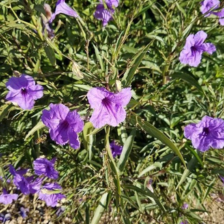

In [20]:
url = 'https://static.inaturalist.org/photos/11430714/medium.jpg'
classify_image_from_url(mobile_imagenet21k.net, url)

,Name,Probability
0,Primula,42.49%
1,Garden Phlox,15.47%
2,Grape Hyacinth,7.54%


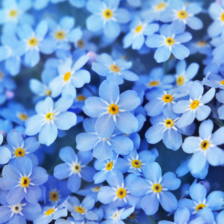

In [21]:
url = 'https://www.farmersalmanac.com/wp-content/uploads/2021/04/forget-me-not-flower-as309740666.jpeg'
classify_image_from_url(mobile_imagenet21k.net, url)

,Name,Probability
0,Sunflower,90.65%
1,Barbeton Daisy,1.97%
2,Black-Eyed Susan,1.77%


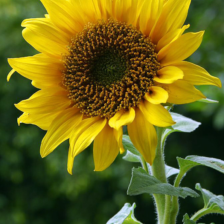

In [22]:
url = 'https://static.educalingo.com/img/en/800/forb.jpg'
classify_image_from_url(mobile_imagenet21k.net, url)

Prueba con una imagen de flor que te guste!

In [23]:
# url = ''
# classify_image_from_url(mobile_imagenet21k.net, url)